In [ ]:
#pro speed up
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Sun Nov 27 20:52:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#%%script echo skipping
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

try:
  os.makedirs("results")
except FileExistsError:
  # directory already exists
  pass

try:
  os.makedirs("img_align_celeba")
  os.makedirs("img_align_celeba/img_align_celeba")
except FileExistsError:
  # directory already exists
  pass

In [ ]:
#%%script echo skipping
! kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:08<00:00, 179MB/s]
100% 1.33G/1.33G [00:08<00:00, 170MB/s]


In [ ]:
#%%script echo skipping
! unzip celeba-dataset.zip

In [ ]:
%%script echo skipping
os.listdir()
os.listdir('img_align_celeba/img_align_celeba/')

skipping


In [ ]:
#setup
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout,Conv2DTranspose,BatchNormalization
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from keras import preprocessing


In [ ]:
#%%script echo skipping
from tqdm import tqdm
from PIL import Image as Img

#Load and resize images
PIC_DIR = f'img_align_celeba/img_align_celeba/'

IMAGES_COUNT = 50000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 64
HEIGHT = 64

#crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff) #for lanzcos filtering
#pic.thumbnail((WIDTH, HEIGHT), Image.LANCZOS) # for lanzcos filtering
#went with min max because I wasnt sure about the side effects
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained'

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    images.append( np.array((Img.open(PIC_DIR + pic_file).crop(crop)).resize((64,64))) ) #crop just the face

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min())) #min max normalization to 0 to 1 sigmoid. 255 is max
    images[i] = images[i]*2 - 1  #need to scale it to -1 to 1 for tanh
    
images = np.array(images) 

len(images)

100%|██████████| 50000/50000 [00:47<00:00, 1060.58it/s]


50000

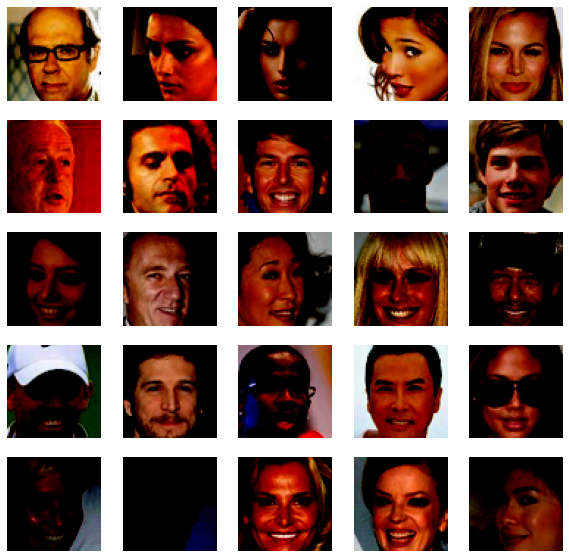

In [ ]:
#%%script echo skipping
#Display first 25 images
#note there is an issue with colab with GPU right now
#bug is that you cant suppress warning
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
#warning are caused by tanh scaling, but matplotlib handles it just fine
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:
#generator
latent_noise_shape = 100
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[latent_noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation='tanh'))
#went standard DCGANs with relu activation and batch normailization 
#note tanh can instead be sigmoid, but you will need to comment out the tanh scaling inthe image processing
#tanh seems to converge better than sigmoid from my own tests
#theory from DCGANs paper as well as: https://mvschamanth.medium.com/activation-functions-why-tanh-outperforms-logistic-sigmoid-3f26469ac0d1

In [ ]:
#discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64, 3]))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
#I had to downgrade the discriminator to the one above as the discriminator was winning too hard
#added dropouts and made the system shallow to make it weaker, also went with 3,3 instead of 4,4
#saving the bottom discriminator as it does when if I load a saved generator
#below is a stronger discriminator for testing later
#note 2, I save the weights for the generator after 300 cycles then used those weights against 
#the strong discriminator. The sytem collapsed. 
#more tests will need to be run to get this to work

# discriminator=Sequential()
# discriminator.add(Conv2D(32, kernel_size=4, strides=2, padding="same",input_shape=[64,64, 3]))
# discriminator.add(Conv2D(64, kernel_size=4, strides=2, padding="same"))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(BatchNormalization())
# discriminator.add(Dropout(0.4))
# discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(BatchNormalization())
# discriminator.add(Dropout(0.4))
# discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
# discriminator.add(LeakyReLU(0.2))
# discriminator.add(Flatten())
# discriminator.add(Dropout(0.4))
# discriminator.add(Dense(1,activation='sigmoid'))

# optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
# discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
#generator to discriminator cycle
GAN = Sequential([generator,discriminator])
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False
GAN.compile(optimizer='adam',loss='binary_crossentropy')
GAN.layers

#OPTIMIZER
#I tried RMS zero_grad and adam. Adam works best. This agrees with: https://towardsdatascience.com/understanding-and-optimizing-gans-going-back-to-first-principles-e5df8835ae18
# sample RMS
# optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
# GAN.compile(optimizer=optimizer, loss='binary_crossentropy')

#LOSS
#I did not get enough time to try wasserstein loss, but it should in theory work better than entropy
#https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/

In [ ]:
# part of my experiment to introduce noise per epoch.
# never got this to work consistently 
def get_noise(epoch):
  if epoch < 10:
    return 0.05
  else:
    return 0.0

In [ ]:
epochs = 300  #choose 300 due to time constraints and because others had success with this
batch_size = 128
#note on the batch, 200 batch of 250 cycles runs faster than 128 batch at 390 cycles. 
#In fact the larger the batch (as long as you have the ram) the faster
#I went with 128 as an increased number of cycles does seem to help the model
D_loss = [] #total discriminator loss
G_loss = [] #total generator loss
Df_loss = [] #discriminator loss fake
Dr_loss = [] #discriminator loss real

Currently on Epoch 1
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390


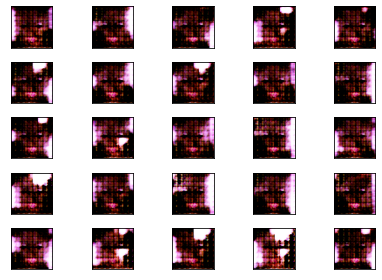

Epoch: 1,  Loss: D_real = 0.072, D_fake = 0.011,  G = 0.911
Currently on Epoch 2
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 2,  Loss: D_real = 0.046, D_fake = 0.009,  G = 0.811
Currently on Epoch 3
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 3,  Loss: D_real = 5.318, D_fake = 0.239,  G = 1.532
Currently on Epoch 4
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 4,  Loss: D_real = 0.042, D_fake = 0.000,  G = 0.000
Currently on Epoch 5
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 5,  Loss: D_real = 0.001, D_fake = 0.017,  G = 0.808
Currently on Epo

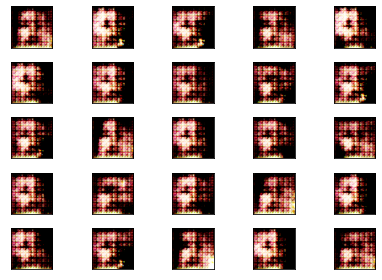

Epoch: 6,  Loss: D_real = 0.077, D_fake = 0.006,  G = 4.790
Currently on Epoch 7
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 7,  Loss: D_real = 0.025, D_fake = 0.074,  G = 0.920
Currently on Epoch 8
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 8,  Loss: D_real = 0.055, D_fake = 0.068,  G = 2.349
Currently on Epoch 9
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 9,  Loss: D_real = 0.256, D_fake = 0.000,  G = 0.443
Currently on Epoch 10
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 10,  Loss: D_real = 0.131, D_fake = 0.035,  G = 3.789
Currently on E

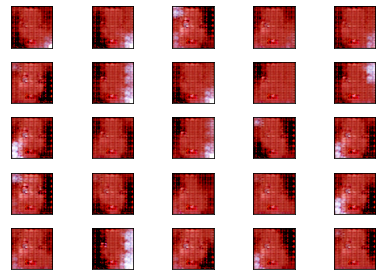

Epoch: 11,  Loss: D_real = 0.168, D_fake = 0.006,  G = 0.218
Currently on Epoch 12
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 12,  Loss: D_real = 0.040, D_fake = 0.061,  G = 0.956
Currently on Epoch 13
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 13,  Loss: D_real = 0.271, D_fake = 0.026,  G = 11.182
Currently on Epoch 14
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 14,  Loss: D_real = 0.417, D_fake = 0.059,  G = 3.763
Currently on Epoch 15
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 15,  Loss: D_real = 0.073, D_fake = 0.016,  G = 7.382
Curren

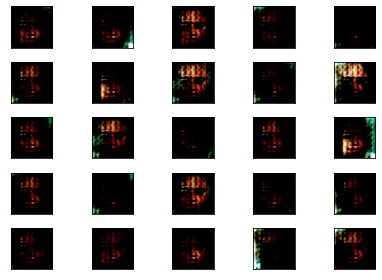

Epoch: 16,  Loss: D_real = 0.336, D_fake = 0.001,  G = 8.049
Currently on Epoch 17
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 17,  Loss: D_real = 0.099, D_fake = 0.029,  G = 6.340
Currently on Epoch 18
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 18,  Loss: D_real = 0.038, D_fake = 0.057,  G = 5.589
Currently on Epoch 19
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 19,  Loss: D_real = 0.060, D_fake = 0.048,  G = 2.245
Currently on Epoch 20
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 20,  Loss: D_real = 0.034, D_fake = 0.105,  G = 5.608
Current

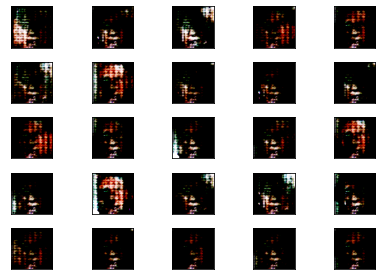

Epoch: 21,  Loss: D_real = 0.135, D_fake = 0.001,  G = 7.531
Currently on Epoch 22
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 22,  Loss: D_real = 0.209, D_fake = 0.095,  G = 2.087
Currently on Epoch 23
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 23,  Loss: D_real = 0.147, D_fake = 0.029,  G = 5.325
Currently on Epoch 24
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 24,  Loss: D_real = 0.000, D_fake = 0.731,  G = 8.804
Currently on Epoch 25
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 25,  Loss: D_real = 0.041, D_fake = 0.020,  G = 7.237
Current

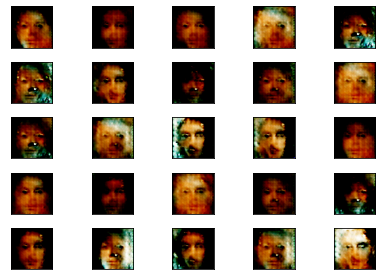

Epoch: 26,  Loss: D_real = 0.360, D_fake = 0.043,  G = 4.748
Currently on Epoch 27
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 27,  Loss: D_real = 0.042, D_fake = 0.012,  G = 6.042
Currently on Epoch 28
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 28,  Loss: D_real = 0.037, D_fake = 0.029,  G = 6.130
Currently on Epoch 29
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 29,  Loss: D_real = 0.205, D_fake = 0.184,  G = 5.744
Currently on Epoch 30
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 30,  Loss: D_real = 0.505, D_fake = 0.012,  G = 15.121
Curren

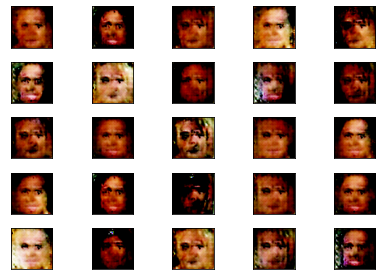

Epoch: 31,  Loss: D_real = 0.409, D_fake = 0.166,  G = 3.806
Currently on Epoch 32
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 32,  Loss: D_real = 0.119, D_fake = 0.063,  G = 1.943
Currently on Epoch 33
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 33,  Loss: D_real = 0.161, D_fake = 0.091,  G = 4.412
Currently on Epoch 34
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 34,  Loss: D_real = 0.132, D_fake = 0.071,  G = 5.688
Currently on Epoch 35
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 35,  Loss: D_real = 0.237, D_fake = 0.088,  G = 5.444
Current

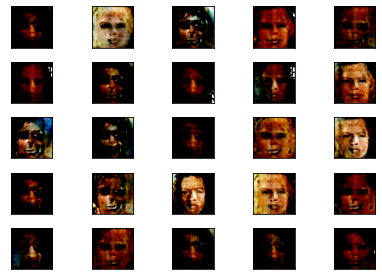

Epoch: 36,  Loss: D_real = 0.563, D_fake = 0.089,  G = 4.984
Currently on Epoch 37
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 37,  Loss: D_real = 0.151, D_fake = 0.202,  G = 4.972
Currently on Epoch 38
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 38,  Loss: D_real = 0.189, D_fake = 0.202,  G = 3.646
Currently on Epoch 39
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 39,  Loss: D_real = 0.217, D_fake = 0.066,  G = 6.832
Currently on Epoch 40
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 40,  Loss: D_real = 0.081, D_fake = 0.046,  G = 6.526
Current

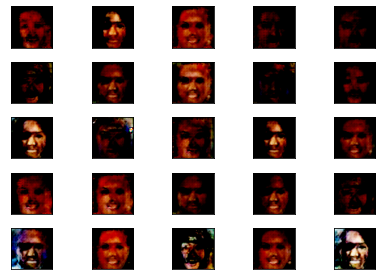

Epoch: 41,  Loss: D_real = 0.447, D_fake = 0.025,  G = 8.589
Currently on Epoch 42
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 42,  Loss: D_real = 0.073, D_fake = 0.018,  G = 6.455
Currently on Epoch 43
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 43,  Loss: D_real = 0.213, D_fake = 0.729,  G = 6.229
Currently on Epoch 44
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 44,  Loss: D_real = 0.102, D_fake = 0.127,  G = 5.637
Currently on Epoch 45
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 45,  Loss: D_real = 0.829, D_fake = 0.148,  G = 4.696
Current

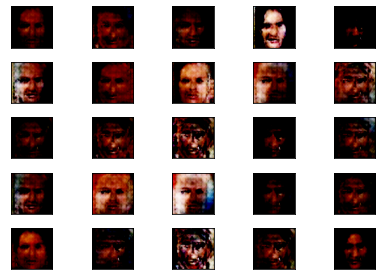

Epoch: 46,  Loss: D_real = 0.222, D_fake = 0.024,  G = 4.573
Currently on Epoch 47
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 47,  Loss: D_real = 0.068, D_fake = 0.337,  G = 6.199
Currently on Epoch 48
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 48,  Loss: D_real = 0.107, D_fake = 0.219,  G = 6.201
Currently on Epoch 49
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 49,  Loss: D_real = 0.187, D_fake = 0.151,  G = 3.431
Currently on Epoch 50
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 50,  Loss: D_real = 0.112, D_fake = 0.044,  G = 7.115
Current

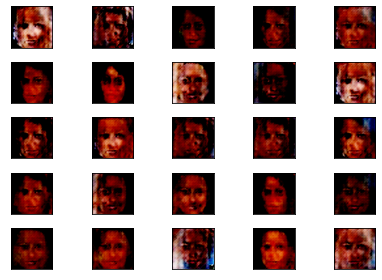

Epoch: 51,  Loss: D_real = 0.376, D_fake = 0.096,  G = 5.361
Currently on Epoch 52
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 52,  Loss: D_real = 0.160, D_fake = 0.079,  G = 7.084
Currently on Epoch 53
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 53,  Loss: D_real = 0.072, D_fake = 0.182,  G = 3.897
Currently on Epoch 54
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 54,  Loss: D_real = 0.107, D_fake = 0.264,  G = 5.567
Currently on Epoch 55
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 55,  Loss: D_real = 0.172, D_fake = 0.012,  G = 7.740
Current

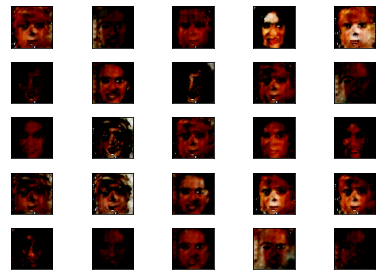

Epoch: 56,  Loss: D_real = 0.060, D_fake = 0.145,  G = 5.314
Currently on Epoch 57
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 57,  Loss: D_real = 0.043, D_fake = 0.012,  G = 7.269
Currently on Epoch 58
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 58,  Loss: D_real = 0.719, D_fake = 0.065,  G = 7.183
Currently on Epoch 59
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 59,  Loss: D_real = 0.054, D_fake = 0.151,  G = 8.880
Currently on Epoch 60
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 60,  Loss: D_real = 0.116, D_fake = 0.021,  G = 7.518
Current

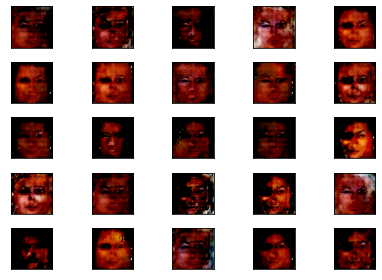

Epoch: 61,  Loss: D_real = 0.055, D_fake = 0.034,  G = 8.248
Currently on Epoch 62
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 62,  Loss: D_real = 0.501, D_fake = 0.032,  G = 5.941
Currently on Epoch 63
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 63,  Loss: D_real = 0.746, D_fake = 0.410,  G = 4.366
Currently on Epoch 64
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 64,  Loss: D_real = 0.253, D_fake = 0.045,  G = 7.686
Currently on Epoch 65
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 65,  Loss: D_real = 0.080, D_fake = 0.097,  G = 5.475
Current

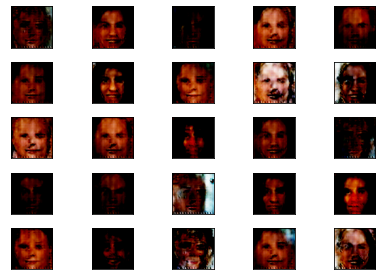

Epoch: 66,  Loss: D_real = 0.009, D_fake = 0.064,  G = 5.729
Currently on Epoch 67
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 67,  Loss: D_real = 0.080, D_fake = 0.114,  G = 6.348
Currently on Epoch 68
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 68,  Loss: D_real = 0.210, D_fake = 0.062,  G = 6.605
Currently on Epoch 69
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 69,  Loss: D_real = 0.066, D_fake = 0.117,  G = 6.318
Currently on Epoch 70
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 70,  Loss: D_real = 0.147, D_fake = 0.088,  G = 5.957
Current

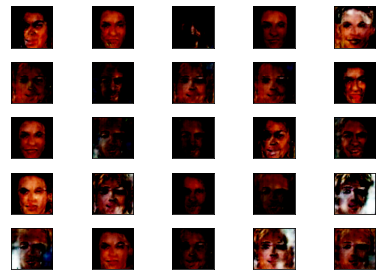

Epoch: 71,  Loss: D_real = 0.055, D_fake = 0.109,  G = 6.547
Currently on Epoch 72
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 72,  Loss: D_real = 0.150, D_fake = 0.057,  G = 5.574
Currently on Epoch 73
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 73,  Loss: D_real = 0.091, D_fake = 0.129,  G = 8.775
Currently on Epoch 74
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 74,  Loss: D_real = 0.064, D_fake = 0.060,  G = 7.388
Currently on Epoch 75
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 75,  Loss: D_real = 0.146, D_fake = 0.056,  G = 7.328
Current

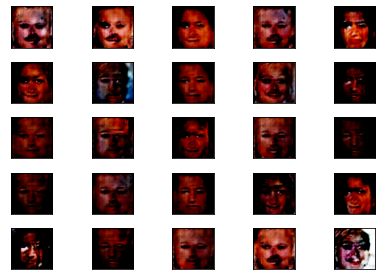

Epoch: 76,  Loss: D_real = 0.046, D_fake = 0.018,  G = 6.903
Currently on Epoch 77
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 77,  Loss: D_real = 0.066, D_fake = 0.109,  G = 6.797
Currently on Epoch 78
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 78,  Loss: D_real = 0.069, D_fake = 0.072,  G = 5.952
Currently on Epoch 79
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 79,  Loss: D_real = 0.049, D_fake = 0.129,  G = 5.775
Currently on Epoch 80
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 80,  Loss: D_real = 0.319, D_fake = 0.199,  G = 5.513
Current

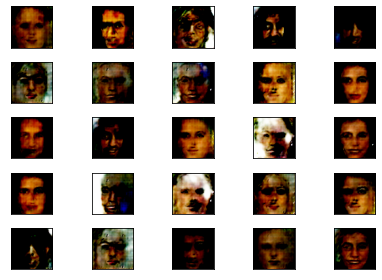

Epoch: 81,  Loss: D_real = 0.031, D_fake = 0.162,  G = 5.471
Currently on Epoch 82
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 82,  Loss: D_real = 0.103, D_fake = 0.430,  G = 5.277
Currently on Epoch 83
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 83,  Loss: D_real = 0.089, D_fake = 0.031,  G = 6.599
Currently on Epoch 84
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 84,  Loss: D_real = 0.186, D_fake = 0.045,  G = 6.108
Currently on Epoch 85
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 85,  Loss: D_real = 0.119, D_fake = 0.032,  G = 6.056
Current

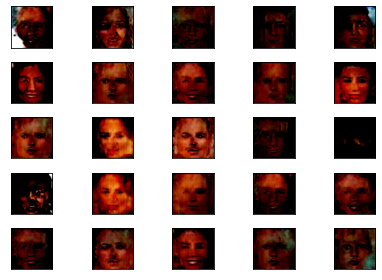

Epoch: 86,  Loss: D_real = 0.246, D_fake = 0.379,  G = 5.762
Currently on Epoch 87
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 87,  Loss: D_real = 0.121, D_fake = 0.057,  G = 5.938
Currently on Epoch 88
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 88,  Loss: D_real = 0.117, D_fake = 0.034,  G = 7.327
Currently on Epoch 89
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 89,  Loss: D_real = 0.037, D_fake = 0.182,  G = 7.427
Currently on Epoch 90
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 90,  Loss: D_real = 1.658, D_fake = 0.463,  G = 9.494
Current

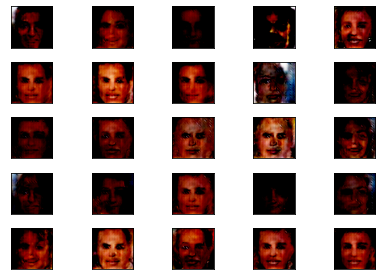

Epoch: 91,  Loss: D_real = 0.432, D_fake = 0.556,  G = 6.160
Currently on Epoch 92
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 92,  Loss: D_real = 0.045, D_fake = 0.219,  G = 5.262
Currently on Epoch 93
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 93,  Loss: D_real = 1.754, D_fake = 0.079,  G = 6.658
Currently on Epoch 94
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 94,  Loss: D_real = 0.032, D_fake = 0.349,  G = 8.738
Currently on Epoch 95
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 95,  Loss: D_real = 0.432, D_fake = 0.288,  G = 5.134
Current

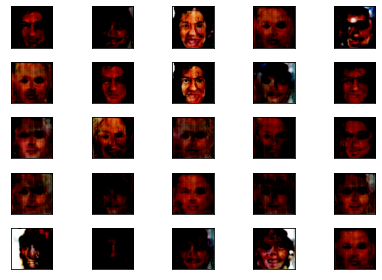

Epoch: 96,  Loss: D_real = 0.522, D_fake = 0.105,  G = 5.458
Currently on Epoch 97
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 97,  Loss: D_real = 0.317, D_fake = 0.049,  G = 6.772
Currently on Epoch 98
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 98,  Loss: D_real = 0.129, D_fake = 0.122,  G = 4.569
Currently on Epoch 99
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 99,  Loss: D_real = 0.184, D_fake = 0.176,  G = 5.279
Currently on Epoch 100
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 100,  Loss: D_real = 0.310, D_fake = 0.267,  G = 4.658
Curre

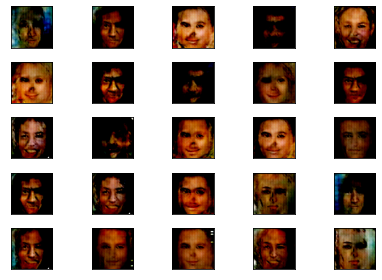

Epoch: 101,  Loss: D_real = 0.011, D_fake = 0.015,  G = 8.576
Currently on Epoch 102
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 102,  Loss: D_real = 0.453, D_fake = 0.326,  G = 6.751
Currently on Epoch 103
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 103,  Loss: D_real = 0.053, D_fake = 0.024,  G = 7.428
Currently on Epoch 104
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 104,  Loss: D_real = 0.257, D_fake = 0.302,  G = 5.194
Currently on Epoch 105
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 105,  Loss: D_real = 0.663, D_fake = 0.189,  G = 6.13

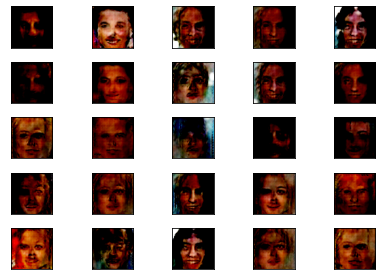

Epoch: 106,  Loss: D_real = 0.255, D_fake = 0.050,  G = 7.167
Currently on Epoch 107
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 107,  Loss: D_real = 0.162, D_fake = 0.036,  G = 6.369
Currently on Epoch 108
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 108,  Loss: D_real = 0.237, D_fake = 0.050,  G = 6.615
Currently on Epoch 109
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 109,  Loss: D_real = 0.126, D_fake = 0.028,  G = 6.038
Currently on Epoch 110
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 110,  Loss: D_real = 0.327, D_fake = 0.201,  G = 5.28

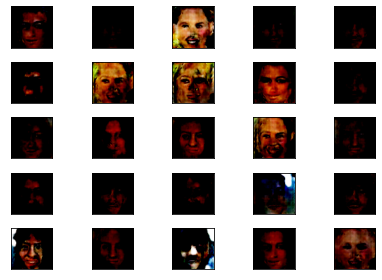

Epoch: 111,  Loss: D_real = 0.078, D_fake = 0.208,  G = 4.074
Currently on Epoch 112
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 112,  Loss: D_real = 0.382, D_fake = 0.674,  G = 3.572
Currently on Epoch 113
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 113,  Loss: D_real = 0.068, D_fake = 0.023,  G = 6.388
Currently on Epoch 114
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 114,  Loss: D_real = 0.466, D_fake = 0.340,  G = 4.102
Currently on Epoch 115
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 115,  Loss: D_real = 0.049, D_fake = 0.497,  G = 9.32

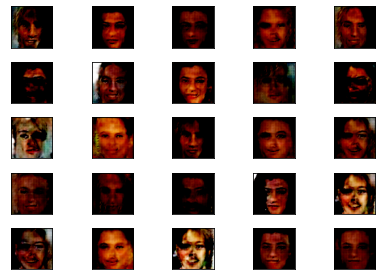

Epoch: 116,  Loss: D_real = 0.114, D_fake = 0.070,  G = 5.276
Currently on Epoch 117
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 117,  Loss: D_real = 0.291, D_fake = 0.026,  G = 6.121
Currently on Epoch 118
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 118,  Loss: D_real = 0.137, D_fake = 0.205,  G = 3.844
Currently on Epoch 119
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 119,  Loss: D_real = 0.150, D_fake = 0.120,  G = 4.536
Currently on Epoch 120
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 120,  Loss: D_real = 0.275, D_fake = 0.190,  G = 5.05

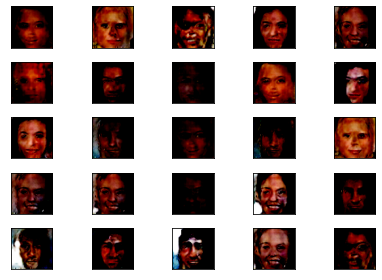

Epoch: 121,  Loss: D_real = 0.845, D_fake = 0.196,  G = 4.301
Currently on Epoch 122
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 122,  Loss: D_real = 0.083, D_fake = 0.140,  G = 6.873
Currently on Epoch 123
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 123,  Loss: D_real = 0.297, D_fake = 0.233,  G = 3.785
Currently on Epoch 124
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 124,  Loss: D_real = 0.083, D_fake = 0.033,  G = 6.573
Currently on Epoch 125
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 125,  Loss: D_real = 0.085, D_fake = 0.075,  G = 5.94

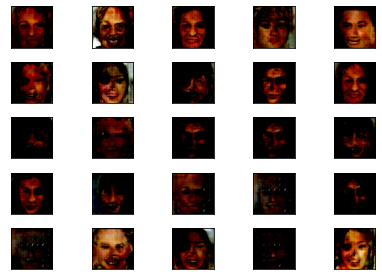

Epoch: 126,  Loss: D_real = 0.339, D_fake = 0.295,  G = 4.674
Currently on Epoch 127
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 127,  Loss: D_real = 0.374, D_fake = 0.130,  G = 4.059
Currently on Epoch 128
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 128,  Loss: D_real = 0.344, D_fake = 0.073,  G = 5.609
Currently on Epoch 129
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 129,  Loss: D_real = 0.922, D_fake = 0.542,  G = 3.782
Currently on Epoch 130
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 130,  Loss: D_real = 0.211, D_fake = 0.227,  G = 5.19

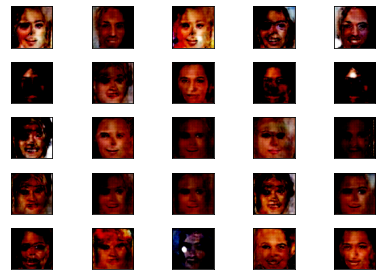

Epoch: 131,  Loss: D_real = 0.092, D_fake = 0.088,  G = 4.980
Currently on Epoch 132
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 132,  Loss: D_real = 0.055, D_fake = 0.025,  G = 5.936
Currently on Epoch 133
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 133,  Loss: D_real = 0.899, D_fake = 0.463,  G = 3.414
Currently on Epoch 134
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 134,  Loss: D_real = 0.221, D_fake = 0.153,  G = 4.704
Currently on Epoch 135
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 135,  Loss: D_real = 0.163, D_fake = 0.305,  G = 4.08

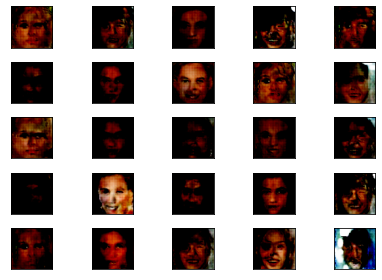

Epoch: 136,  Loss: D_real = 0.344, D_fake = 0.179,  G = 4.559
Currently on Epoch 137
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 137,  Loss: D_real = 0.701, D_fake = 0.409,  G = 3.292
Currently on Epoch 138
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 138,  Loss: D_real = 0.490, D_fake = 0.460,  G = 4.420
Currently on Epoch 139
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 139,  Loss: D_real = 0.358, D_fake = 0.045,  G = 5.110
Currently on Epoch 140
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 140,  Loss: D_real = 0.160, D_fake = 0.113,  G = 5.20

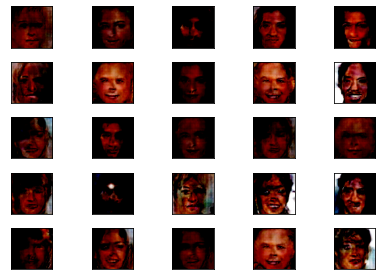

Epoch: 141,  Loss: D_real = 0.135, D_fake = 0.101,  G = 4.776
Currently on Epoch 142
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 142,  Loss: D_real = 0.241, D_fake = 0.424,  G = 3.561
Currently on Epoch 143
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 143,  Loss: D_real = 0.498, D_fake = 0.409,  G = 4.757
Currently on Epoch 144
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 144,  Loss: D_real = 0.113, D_fake = 0.051,  G = 6.423
Currently on Epoch 145
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 145,  Loss: D_real = 0.189, D_fake = 0.475,  G = 4.11

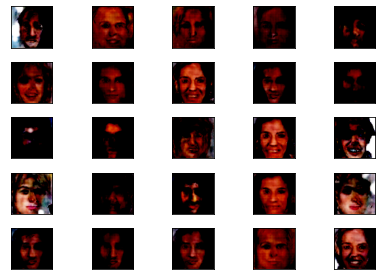

Epoch: 146,  Loss: D_real = 0.090, D_fake = 0.031,  G = 5.155
Currently on Epoch 147
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 147,  Loss: D_real = 0.175, D_fake = 0.025,  G = 8.069
Currently on Epoch 148
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 148,  Loss: D_real = 0.226, D_fake = 0.044,  G = 7.146
Currently on Epoch 149
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 149,  Loss: D_real = 0.190, D_fake = 0.174,  G = 4.776
Currently on Epoch 150
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 150,  Loss: D_real = 0.135, D_fake = 0.027,  G = 5.69

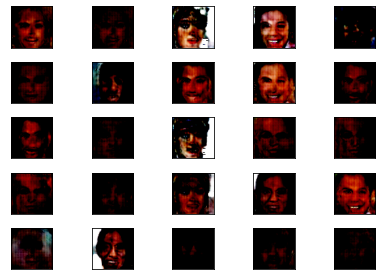

Epoch: 151,  Loss: D_real = 0.251, D_fake = 0.074,  G = 5.511
Currently on Epoch 152
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 152,  Loss: D_real = 0.076, D_fake = 0.072,  G = 5.870
Currently on Epoch 153
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 153,  Loss: D_real = 0.296, D_fake = 0.140,  G = 4.401
Currently on Epoch 154
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 154,  Loss: D_real = 0.709, D_fake = 0.155,  G = 5.882
Currently on Epoch 155
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 155,  Loss: D_real = 0.420, D_fake = 0.444,  G = 4.77

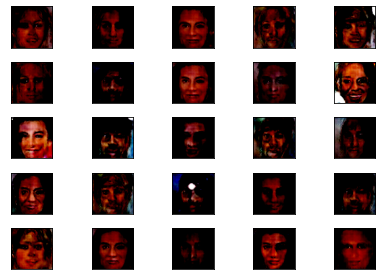

Epoch: 156,  Loss: D_real = 0.150, D_fake = 0.180,  G = 4.799
Currently on Epoch 157
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 157,  Loss: D_real = 0.466, D_fake = 0.304,  G = 4.249
Currently on Epoch 158
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 158,  Loss: D_real = 0.324, D_fake = 0.039,  G = 8.218
Currently on Epoch 159
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 159,  Loss: D_real = 0.113, D_fake = 0.107,  G = 6.554
Currently on Epoch 160
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 160,  Loss: D_real = 0.174, D_fake = 0.052,  G = 4.62

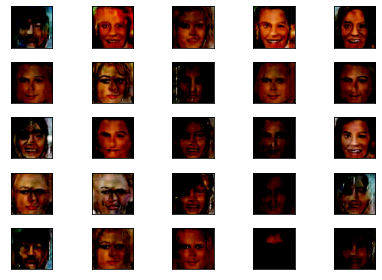

Epoch: 161,  Loss: D_real = 0.130, D_fake = 0.058,  G = 6.124
Currently on Epoch 162
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 162,  Loss: D_real = 0.276, D_fake = 0.244,  G = 3.433
Currently on Epoch 163
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 163,  Loss: D_real = 0.741, D_fake = 0.308,  G = 3.852
Currently on Epoch 164
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 164,  Loss: D_real = 0.387, D_fake = 0.251,  G = 5.103
Currently on Epoch 165
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 165,  Loss: D_real = 0.503, D_fake = 0.482,  G = 3.70

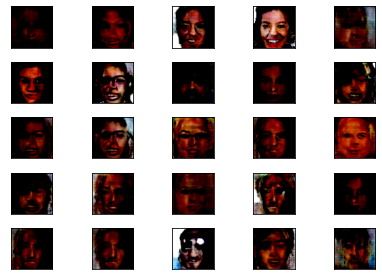

Epoch: 166,  Loss: D_real = 0.065, D_fake = 0.071,  G = 5.779
Currently on Epoch 167
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 167,  Loss: D_real = 0.808, D_fake = 0.329,  G = 3.177
Currently on Epoch 168
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 168,  Loss: D_real = 0.195, D_fake = 0.054,  G = 5.239
Currently on Epoch 169
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 169,  Loss: D_real = 0.119, D_fake = 0.155,  G = 3.820
Currently on Epoch 170
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 170,  Loss: D_real = 0.080, D_fake = 0.092,  G = 4.51

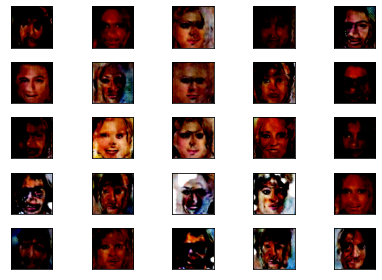

Epoch: 171,  Loss: D_real = 0.262, D_fake = 0.207,  G = 4.491
Currently on Epoch 172
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 172,  Loss: D_real = 0.086, D_fake = 0.056,  G = 6.608
Currently on Epoch 173
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 173,  Loss: D_real = 0.786, D_fake = 0.771,  G = 3.172
Currently on Epoch 174
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 174,  Loss: D_real = 0.299, D_fake = 0.238,  G = 3.899
Currently on Epoch 175
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 175,  Loss: D_real = 0.439, D_fake = 0.277,  G = 3.32

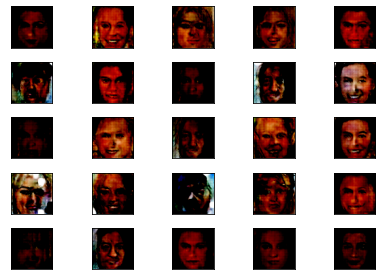

Epoch: 176,  Loss: D_real = 0.495, D_fake = 0.165,  G = 5.363
Currently on Epoch 177
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 177,  Loss: D_real = 0.065, D_fake = 0.301,  G = 4.759
Currently on Epoch 178
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 178,  Loss: D_real = 0.239, D_fake = 0.588,  G = 4.772
Currently on Epoch 179
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 179,  Loss: D_real = 0.108, D_fake = 0.083,  G = 4.843
Currently on Epoch 180
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 180,  Loss: D_real = 0.293, D_fake = 0.217,  G = 4.34

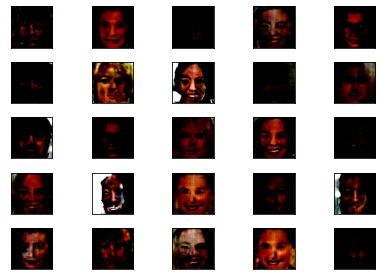

Epoch: 181,  Loss: D_real = 0.365, D_fake = 0.406,  G = 4.141
Currently on Epoch 182
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 182,  Loss: D_real = 0.192, D_fake = 0.157,  G = 5.508
Currently on Epoch 183
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 183,  Loss: D_real = 0.268, D_fake = 0.210,  G = 5.080
Currently on Epoch 184
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 184,  Loss: D_real = 0.375, D_fake = 0.100,  G = 4.178
Currently on Epoch 185
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 185,  Loss: D_real = 0.299, D_fake = 0.199,  G = 4.20

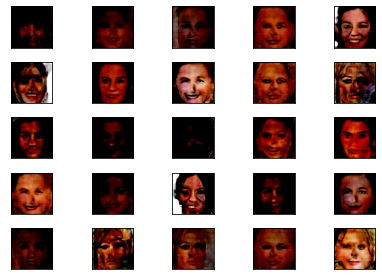

Epoch: 186,  Loss: D_real = 0.405, D_fake = 0.455,  G = 4.066
Currently on Epoch 187
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 187,  Loss: D_real = 0.065, D_fake = 0.084,  G = 4.918
Currently on Epoch 188
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 188,  Loss: D_real = 0.168, D_fake = 0.072,  G = 5.001
Currently on Epoch 189
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 189,  Loss: D_real = 0.851, D_fake = 0.255,  G = 4.128
Currently on Epoch 190
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 190,  Loss: D_real = 0.365, D_fake = 0.267,  G = 3.57

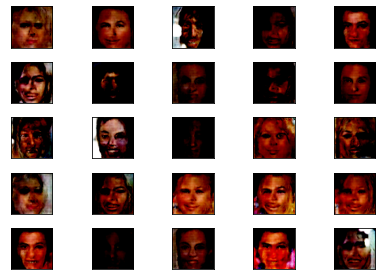

Epoch: 191,  Loss: D_real = 0.319, D_fake = 0.315,  G = 4.635
Currently on Epoch 192
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 192,  Loss: D_real = 0.077, D_fake = 0.320,  G = 4.806
Currently on Epoch 193
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 193,  Loss: D_real = 0.217, D_fake = 0.112,  G = 5.238
Currently on Epoch 194
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 194,  Loss: D_real = 0.337, D_fake = 0.065,  G = 4.521
Currently on Epoch 195
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 195,  Loss: D_real = 0.771, D_fake = 0.261,  G = 3.84

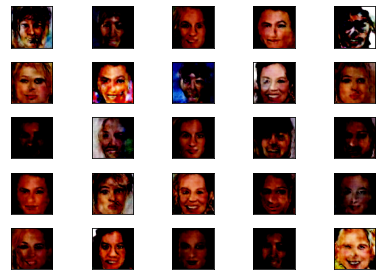

Epoch: 196,  Loss: D_real = 0.643, D_fake = 0.651,  G = 3.387
Currently on Epoch 197
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 197,  Loss: D_real = 0.748, D_fake = 0.346,  G = 3.481
Currently on Epoch 198
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 198,  Loss: D_real = 0.046, D_fake = 0.032,  G = 4.801
Currently on Epoch 199
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 199,  Loss: D_real = 2.396, D_fake = 0.362,  G = 3.091
Currently on Epoch 200
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 200,  Loss: D_real = 0.738, D_fake = 0.318,  G = 3.98

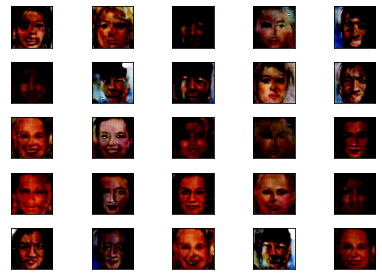

Epoch: 201,  Loss: D_real = 0.121, D_fake = 0.098,  G = 4.996
Currently on Epoch 202
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 202,  Loss: D_real = 0.127, D_fake = 0.068,  G = 5.806
Currently on Epoch 203
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 203,  Loss: D_real = 0.316, D_fake = 0.110,  G = 5.330
Currently on Epoch 204
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 204,  Loss: D_real = 0.487, D_fake = 0.096,  G = 5.481
Currently on Epoch 205
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 205,  Loss: D_real = 1.061, D_fake = 0.189,  G = 4.74

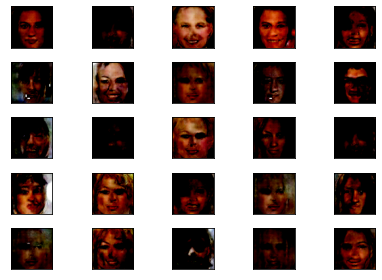

Epoch: 206,  Loss: D_real = 0.415, D_fake = 0.057,  G = 5.218
Currently on Epoch 207
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 207,  Loss: D_real = 0.143, D_fake = 0.137,  G = 4.551
Currently on Epoch 208
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 208,  Loss: D_real = 0.105, D_fake = 0.093,  G = 4.475
Currently on Epoch 209
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 209,  Loss: D_real = 0.255, D_fake = 0.141,  G = 3.710
Currently on Epoch 210
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 210,  Loss: D_real = 0.150, D_fake = 0.067,  G = 4.56

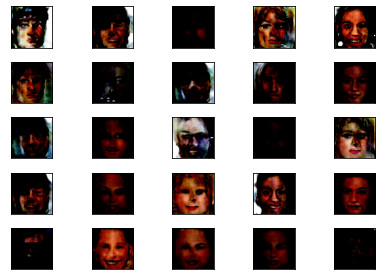

Epoch: 211,  Loss: D_real = 0.712, D_fake = 0.107,  G = 5.161
Currently on Epoch 212
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 212,  Loss: D_real = 0.159, D_fake = 0.096,  G = 4.683
Currently on Epoch 213
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 213,  Loss: D_real = 0.641, D_fake = 0.221,  G = 3.609
Currently on Epoch 214
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 214,  Loss: D_real = 0.313, D_fake = 0.203,  G = 3.799
Currently on Epoch 215
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 215,  Loss: D_real = 0.085, D_fake = 0.051,  G = 4.94

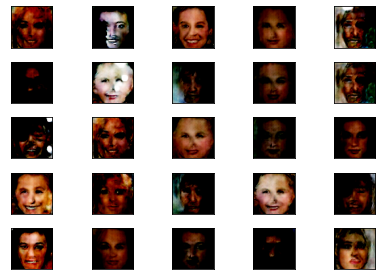

Epoch: 216,  Loss: D_real = 0.240, D_fake = 0.107,  G = 4.645
Currently on Epoch 217
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 217,  Loss: D_real = 0.032, D_fake = 0.120,  G = 4.608
Currently on Epoch 218
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 218,  Loss: D_real = 0.265, D_fake = 0.176,  G = 4.304
Currently on Epoch 219
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 219,  Loss: D_real = 0.509, D_fake = 0.076,  G = 6.079
Currently on Epoch 220
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 220,  Loss: D_real = 0.094, D_fake = 0.084,  G = 4.99

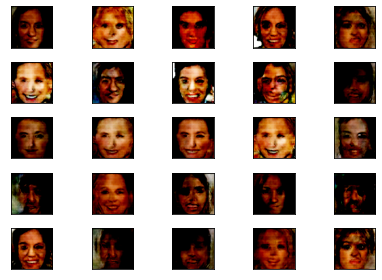

Epoch: 221,  Loss: D_real = 0.061, D_fake = 0.117,  G = 5.126
Currently on Epoch 222
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 222,  Loss: D_real = 0.393, D_fake = 0.397,  G = 3.575
Currently on Epoch 223
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 223,  Loss: D_real = 0.892, D_fake = 0.218,  G = 3.265
Currently on Epoch 224
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 224,  Loss: D_real = 0.841, D_fake = 0.332,  G = 3.416
Currently on Epoch 225
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 225,  Loss: D_real = 0.369, D_fake = 0.162,  G = 3.96

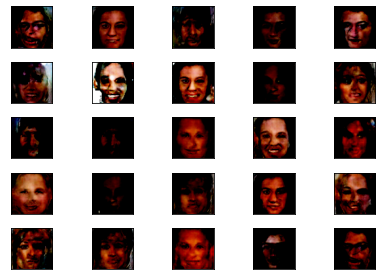

Epoch: 226,  Loss: D_real = 0.657, D_fake = 0.957,  G = 3.398
Currently on Epoch 227
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 227,  Loss: D_real = 0.862, D_fake = 0.436,  G = 3.180
Currently on Epoch 228
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 228,  Loss: D_real = 1.302, D_fake = 0.403,  G = 2.143
Currently on Epoch 229
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 229,  Loss: D_real = 0.726, D_fake = 0.209,  G = 3.442
Currently on Epoch 230
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 230,  Loss: D_real = 0.228, D_fake = 0.155,  G = 3.52

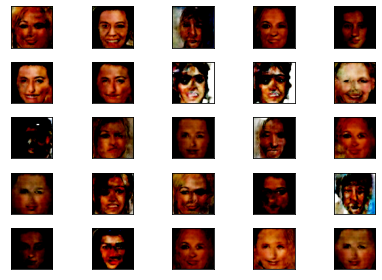

Epoch: 231,  Loss: D_real = 0.299, D_fake = 0.153,  G = 3.528
Currently on Epoch 232
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 232,  Loss: D_real = 0.652, D_fake = 0.267,  G = 2.987
Currently on Epoch 233
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 233,  Loss: D_real = 0.167, D_fake = 0.182,  G = 3.842
Currently on Epoch 234
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 234,  Loss: D_real = 0.223, D_fake = 0.155,  G = 5.112
Currently on Epoch 235
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 235,  Loss: D_real = 0.202, D_fake = 0.172,  G = 4.31

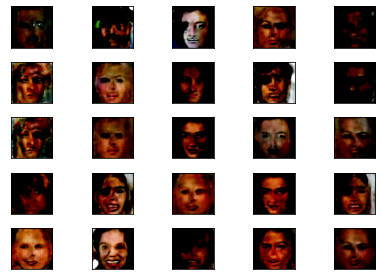

Epoch: 236,  Loss: D_real = 0.147, D_fake = 0.083,  G = 4.435
Currently on Epoch 237
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 237,  Loss: D_real = 0.186, D_fake = 0.092,  G = 4.785
Currently on Epoch 238
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 238,  Loss: D_real = 0.096, D_fake = 0.168,  G = 4.156
Currently on Epoch 239
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 239,  Loss: D_real = 0.119, D_fake = 0.240,  G = 4.710
Currently on Epoch 240
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 240,  Loss: D_real = 0.390, D_fake = 0.705,  G = 3.81

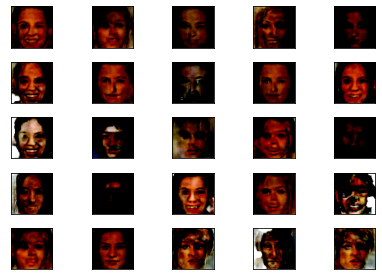

Epoch: 241,  Loss: D_real = 0.447, D_fake = 0.453,  G = 3.025
Currently on Epoch 242
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 242,  Loss: D_real = 0.135, D_fake = 0.199,  G = 4.336
Currently on Epoch 243
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 243,  Loss: D_real = 0.758, D_fake = 0.408,  G = 3.514
Currently on Epoch 244
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 244,  Loss: D_real = 0.657, D_fake = 0.675,  G = 2.881
Currently on Epoch 245
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 245,  Loss: D_real = 0.032, D_fake = 0.042,  G = 5.66

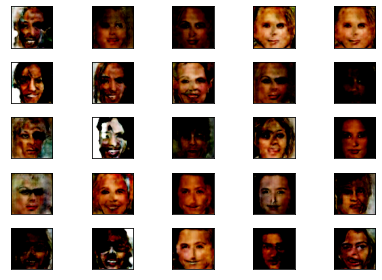

Epoch: 246,  Loss: D_real = 0.070, D_fake = 0.117,  G = 5.359
Currently on Epoch 247
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 247,  Loss: D_real = 0.447, D_fake = 0.269,  G = 3.342
Currently on Epoch 248
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 248,  Loss: D_real = 0.589, D_fake = 0.539,  G = 3.258
Currently on Epoch 249
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 249,  Loss: D_real = 0.527, D_fake = 0.438,  G = 3.363
Currently on Epoch 250
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 250,  Loss: D_real = 0.273, D_fake = 0.287,  G = 4.70

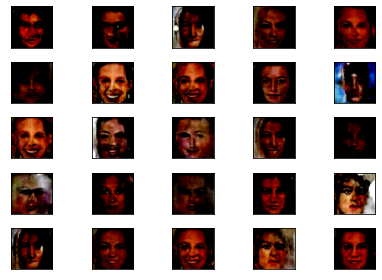

Epoch: 251,  Loss: D_real = 0.608, D_fake = 0.372,  G = 2.632
Currently on Epoch 252
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 252,  Loss: D_real = 0.412, D_fake = 0.215,  G = 4.376
Currently on Epoch 253
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 253,  Loss: D_real = 0.727, D_fake = 0.557,  G = 2.469
Currently on Epoch 254
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 254,  Loss: D_real = 0.590, D_fake = 0.466,  G = 3.748
Currently on Epoch 255
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 255,  Loss: D_real = 0.144, D_fake = 0.061,  G = 6.17

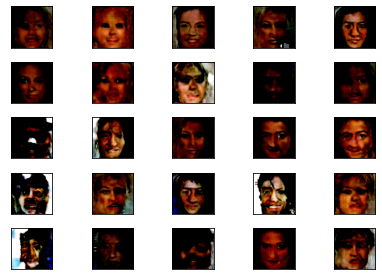

Epoch: 256,  Loss: D_real = 0.114, D_fake = 0.145,  G = 3.695
Currently on Epoch 257
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 257,  Loss: D_real = 0.165, D_fake = 0.134,  G = 4.272
Currently on Epoch 258
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 258,  Loss: D_real = 0.314, D_fake = 0.084,  G = 5.291
Currently on Epoch 259
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 259,  Loss: D_real = 0.170, D_fake = 0.264,  G = 3.326
Currently on Epoch 260
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 260,  Loss: D_real = 0.337, D_fake = 0.271,  G = 4.09

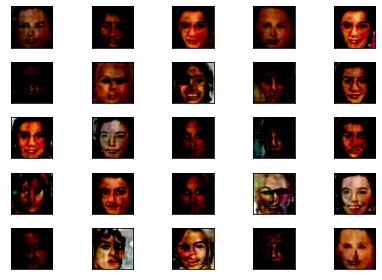

Epoch: 261,  Loss: D_real = 0.289, D_fake = 0.225,  G = 4.659
Currently on Epoch 262
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 262,  Loss: D_real = 0.079, D_fake = 0.186,  G = 4.326
Currently on Epoch 263
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 263,  Loss: D_real = 0.667, D_fake = 0.185,  G = 4.563
Currently on Epoch 264
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 264,  Loss: D_real = 0.038, D_fake = 0.158,  G = 3.933
Currently on Epoch 265
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 265,  Loss: D_real = 0.179, D_fake = 0.065,  G = 5.62

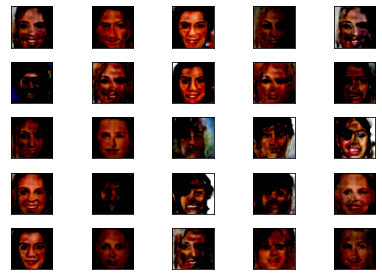

Epoch: 266,  Loss: D_real = 1.161, D_fake = 0.730,  G = 2.276
Currently on Epoch 267
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 267,  Loss: D_real = 0.095, D_fake = 0.141,  G = 4.576
Currently on Epoch 268
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 268,  Loss: D_real = 0.292, D_fake = 0.045,  G = 5.438
Currently on Epoch 269
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 269,  Loss: D_real = 0.456, D_fake = 0.567,  G = 3.360
Currently on Epoch 270
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 270,  Loss: D_real = 0.139, D_fake = 0.106,  G = 4.61

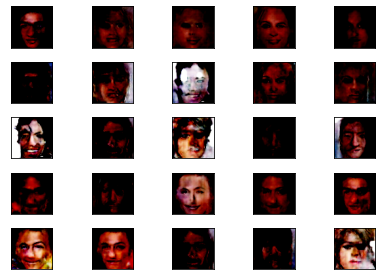

Epoch: 271,  Loss: D_real = 0.262, D_fake = 0.160,  G = 4.062
Currently on Epoch 272
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 272,  Loss: D_real = 0.064, D_fake = 0.128,  G = 5.555
Currently on Epoch 273
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 273,  Loss: D_real = 0.148, D_fake = 0.302,  G = 4.986
Currently on Epoch 274
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 274,  Loss: D_real = 0.128, D_fake = 0.060,  G = 4.921
Currently on Epoch 275
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 275,  Loss: D_real = 0.152, D_fake = 0.128,  G = 4.80

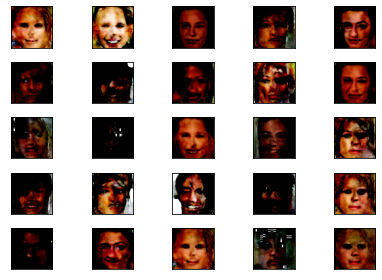

Epoch: 276,  Loss: D_real = 0.315, D_fake = 0.315,  G = 3.761
Currently on Epoch 277
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 277,  Loss: D_real = 0.190, D_fake = 0.129,  G = 4.622
Currently on Epoch 278
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 278,  Loss: D_real = 0.329, D_fake = 0.126,  G = 4.227
Currently on Epoch 279
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 279,  Loss: D_real = 0.060, D_fake = 0.061,  G = 5.969
Currently on Epoch 280
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 280,  Loss: D_real = 0.123, D_fake = 0.107,  G = 5.21

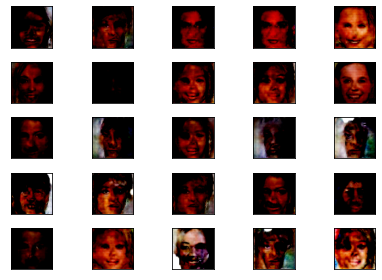

Epoch: 281,  Loss: D_real = 0.421, D_fake = 0.418,  G = 4.032
Currently on Epoch 282
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 282,  Loss: D_real = 0.917, D_fake = 0.285,  G = 3.598
Currently on Epoch 283
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 283,  Loss: D_real = 0.325, D_fake = 0.160,  G = 4.920
Currently on Epoch 284
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 284,  Loss: D_real = 0.894, D_fake = 0.544,  G = 3.673
Currently on Epoch 285
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 285,  Loss: D_real = 0.493, D_fake = 0.206,  G = 3.34

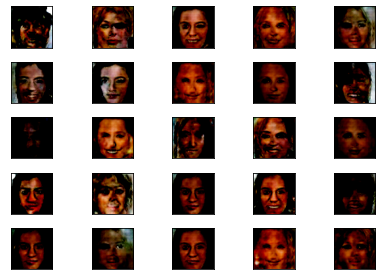

Epoch: 286,  Loss: D_real = 1.096, D_fake = 0.457,  G = 2.978
Currently on Epoch 287
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 287,  Loss: D_real = 0.037, D_fake = 0.105,  G = 5.499
Currently on Epoch 288
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 288,  Loss: D_real = 0.134, D_fake = 0.161,  G = 3.900
Currently on Epoch 289
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 289,  Loss: D_real = 0.236, D_fake = 0.049,  G = 5.086
Currently on Epoch 290
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 290,  Loss: D_real = 0.432, D_fake = 0.295,  G = 4.31

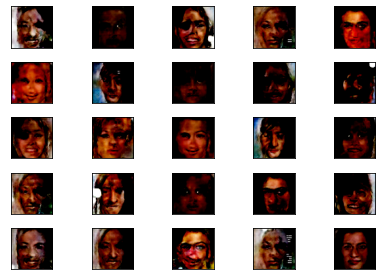

Epoch: 291,  Loss: D_real = 0.418, D_fake = 0.488,  G = 3.916
Currently on Epoch 292
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 292,  Loss: D_real = 0.334, D_fake = 0.120,  G = 4.032
Currently on Epoch 293
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 293,  Loss: D_real = 0.100, D_fake = 0.060,  G = 5.293
Currently on Epoch 294
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 294,  Loss: D_real = 0.368, D_fake = 0.486,  G = 3.371
Currently on Epoch 295
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 295,  Loss: D_real = 0.441, D_fake = 0.311,  G = 3.39

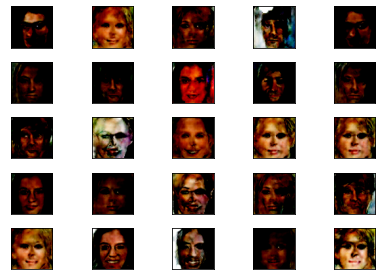

Epoch: 296,  Loss: D_real = 0.460, D_fake = 0.228,  G = 3.840
Currently on Epoch 297
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 297,  Loss: D_real = 0.316, D_fake = 0.110,  G = 5.337
Currently on Epoch 298
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 298,  Loss: D_real = 0.377, D_fake = 0.301,  G = 4.628
Currently on Epoch 299
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390
Epoch: 299,  Loss: D_real = 0.437, D_fake = 0.579,  G = 3.722
Currently on Epoch 300
	Currently on batch number 0 of 390
	Currently on batch number 100 of 390
	Currently on batch number 200 of 390
	Currently on batch number 300 of 390


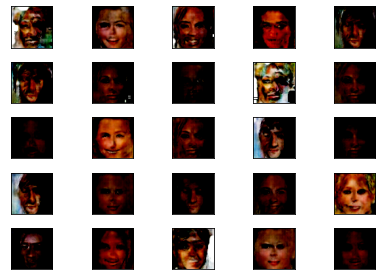

Epoch: 300,  Loss: D_real = 0.754, D_fake = 0.373,  G = 2.567
Training is complete


In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # 1 epoch is a complete cycle of all 50000 images
    # each patch is 128 at a time or 390 batches per epoch
    for i in range(images.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(images)//batch_size}")


        #note the commented out noise I added to the labels. Never got that to work properly
        #more experimentation needed    
        noise=np.random.uniform(-1,1,size=[batch_size,latent_noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = images[i*batch_size:(i+1)*batch_size]
        
        #train on real image
        real_label=np.ones(shape=(batch_size,1))
        #real_label += get_noise(epoch)* np.random.random(train_label.shape)
        discriminator.trainable = True
        dr_loss = discriminator.train_on_batch(train_dataset,real_label)
        
        #train on fake image
        fake_label=np.zeros(shape=(batch_size,1))
        #fake_label += get_noise(epoch)* np.random.random(train_label.shape)
        df_loss = discriminator.train_on_batch(gen_image,fake_label)
        
        noise=np.random.uniform(-1,1,size=[batch_size,latent_noise_shape])
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, real_label)

        #shelving for inconsistent results
        #I rewrote the logic for the generator and discriminator
        #In particular I concatonated the real and fake images for the discriminator
        #into 1 run instead of two. This speeds up the performance of the runs
        #the only downside is that I lose the ability to see both the separate discriminator
        #losses for real and fake, itinstead combines, but its worth the performance improvement
        #I also lose the ability to not run the discriminator, but from experience this
        #doesnt matter as you always want to run the discriminator
        #--------------------------------------------------------------------------------------
        # #discriminator loss
        # true_label = np.ones(shape=(batch_size,1))
        # # noise_true_label = np.ones(shape=(batch_size,1))
        # # noise_true_label += get_noise(epoch)* np.random.random(true_label.shape)

        # false_label = np.zeros(shape=(batch_size,1))
        # # noise_false_label = np.zeros(shape=(batch_size,1))
        # # noise_false_label += get_noise(epoch)* np.random.random(true_label.shape)

        # comb_labels = np.concatenate([true_label, false_label])
        # comb_img = np.concatenate([train_dataset, gen_image])

        # discriminator.trainable = True
        # d_loss = discriminator.train_on_batch(comb_img, comb_labels)

        # #generator loss
        # noise=np.random.uniform(-1,1,size=[batch_size,latent_noise_shape])
        # true_label = np.ones(shape=(batch_size,1))

        # discriminator.trainable = False
        # g_loss = GAN.train_on_batch(noise, true_label)
        #--------------------------------------------------------------------------------------

        #append loss
        D_loss.append(dr_loss+df_loss)
        Dr_loss.append(dr_loss)
        Df_loss.append(df_loss)
        G_loss.append(g_loss)

    #generate result images     
    if (epoch % 5 == 0) or (epoch == epochs-1):
        samples = 25
        for k in range(samples):
            plt.subplot(5, 5, k+1)
            plt.imshow(gen_image[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()

        #save file
        numbering = '{0:03}'.format(epoch)
        plt.savefig(f"results/epoch-{numbering}.png")

        #must be after save file
        plt.show()

    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, dr_loss, df_loss, g_loss))
print('Training is complete')

In [ ]:
#save weights
GAN.save_weights('gan_01.h5')
discriminator.save_weights('dis_01.h5')
generator.save_weights('gen_01.h5')         

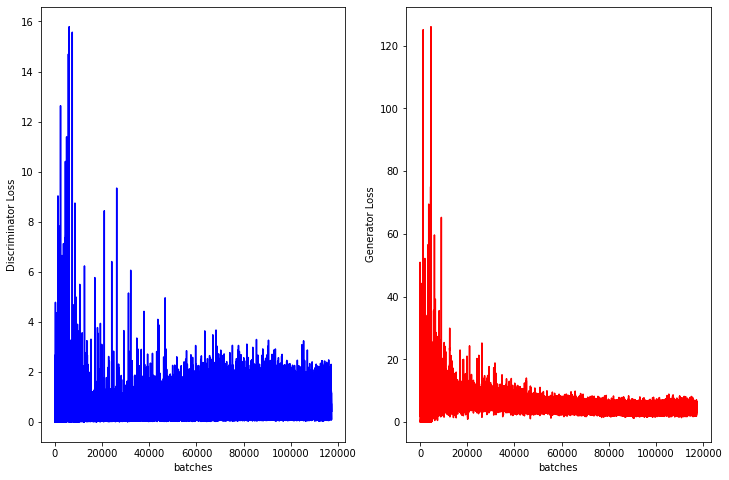

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(D_loss, color='blue')
plt.xlabel('batches')
plt.ylabel('Discriminator Loss')
plt.subplot(122)
plt.plot(G_loss, color='red')
plt.xlabel('batches')
plt.ylabel('Generator Loss')
plt.show()

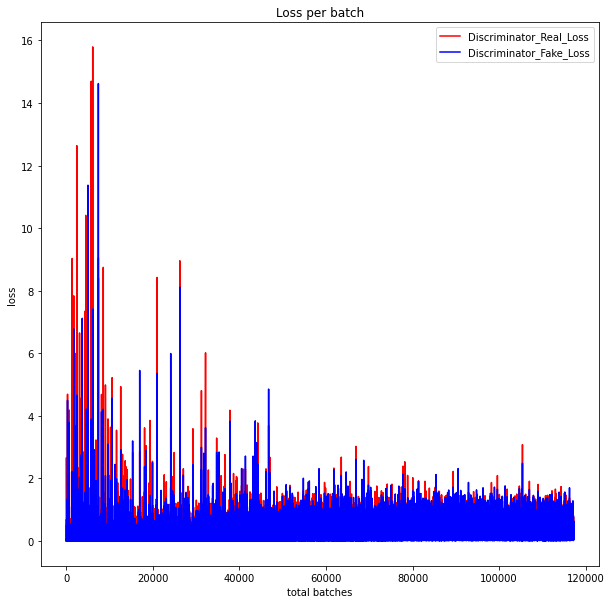

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(Dr_loss,color='red',label='Discriminator_Real_Loss')
plt.plot(Df_loss,color='blue',label='Discriminator_Fake_Loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Loss per batch')
plt.show()

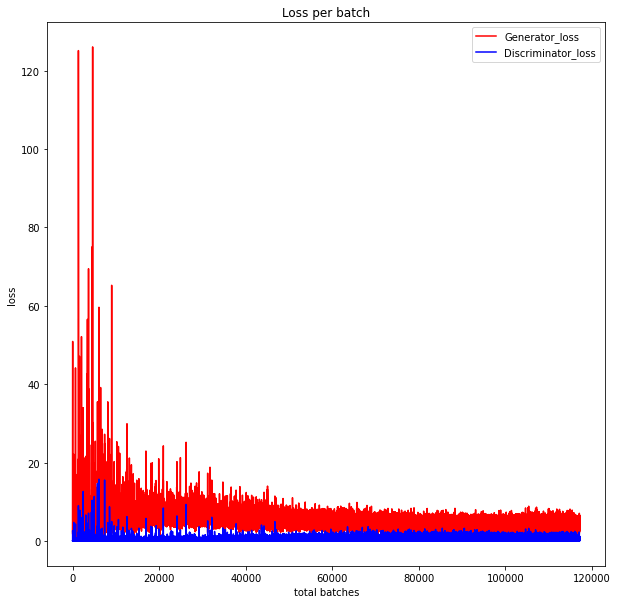

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Loss per batch')
plt.show()


In [ ]:
!zip -r /content/results.zip /content/results/

from google.colab import files
# files.download("results.zip")

#note home is /content/

updating: content/results/ (stored 0%)
updating: content/results/epoch-000.png (deflated 0%)
  adding: content/results/epoch-265.png (deflated 0%)
  adding: content/results/epoch-270.png (deflated 1%)
  adding: content/results/epoch-055.png (deflated 1%)
  adding: content/results/epoch-105.png (deflated 0%)
  adding: content/results/epoch-060.png (deflated 1%)
  adding: content/results/epoch-165.png (deflated 1%)
  adding: content/results/epoch-120.png (deflated 1%)
  adding: content/results/epoch-095.png (deflated 1%)
  adding: content/results/epoch-010.png (deflated 0%)
  adding: content/results/epoch-035.png (deflated 1%)
  adding: content/results/epoch-100.png (deflated 0%)
  adding: content/results/epoch-210.png (deflated 1%)
  adding: content/results/epoch-130.png (deflated 0%)
  adding: content/results/epoch-180.png (deflated 1%)
  adding: content/results/epoch-150.png (deflated 1%)
  adding: content/results/epoch-140.png (deflated 1%)
  adding: content/results/epoch-185.png (de

In [ ]:
len(D_loss)

117198

In [ ]:
# files.download("dis_01.h5")
# files.download("gan_01.h5")
# files.download("gen_01.h5")

In [ ]:
generator.load_weights('gen_01.h5')
samples = 25
noise=np.random.uniform(-1,1,size=[25,latent_noise_shape])
im=generator.predict(noise) 
for k in range(samples):
  plt.subplot(5, 5, k+1)
  plt.imshow(im[k].reshape(64,64,3))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

#save file
numbering = '{0:03}'.format(epoch)
plt.savefig(f"results/epoch-{numbering}.png")

#must be after save file
plt.show()